In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from scipy.stats import pearsonr, spearmanr

import seaborn as sns

In [2]:
EU_day = pd.read_csv("env_covar/EU_daytime_2019.csv", index_col=0).drop("MT", 1)
EU_sun = pd.read_csv("env_covar/EU_sunrise_2019.csv", index_col=0).drop("MT", 1)
EU_hum = pd.read_csv("env_covar/EU_humidity_2010_18.csv", index_col=0).drop("MT", 1) #.dropna(axis=1)
EU_tmp = pd.read_csv("env_covar/EU_temperature_2010_18.csv", index_col=0).drop("MT", 1) #.dropna(axis=1)

US_day = pd.read_csv("env_covar/US_daytime_2019.csv", index_col=0).drop("PR", 1)
US_sun = pd.read_csv("env_covar/US_sunrise_2019.csv", index_col=0).drop("PR", 1)
US_hum = pd.read_csv("env_covar/US_humidity_2010_18.csv", index_col=0).drop("PR", 1)
US_tmp = pd.read_csv("env_covar/US_temperature_2010_18.csv", index_col=0).drop("PR", 1)

In [40]:
#EU_hum.isnull().sum()

### Plot covar correlation

In [31]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    r, _ = pearsonr(x, y)
    rho, _ = spearmanr(x, y)
    ax.scatter( x, y, c=z, **kwargs, label=f"r={r:.3f},ρ={rho:.3f}" )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    #cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    #cbar.ax.set_ylabel('Density')

    return ax

In [20]:
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    rho, _ = spearmanr(x, y)
    ax = plt.gca()
    ax.annotate(f"r = {r:.3f}; ρ={rho:.3f}",
                xy=(.1, .9), xycoords=ax.transAxes)

In [4]:
[[EU_day.shape, EU_sun.shape, EU_hum.shape, EU_tmp.shape],
 [US_day.shape, US_sun.shape, US_hum.shape, US_tmp.shape]]

[[(365, 36), (365, 36), (3285, 36), (3285, 36)],
 [(365, 51), (365, 51), (3285, 51), (3285, 51)]]

#### Hum <=> Temp

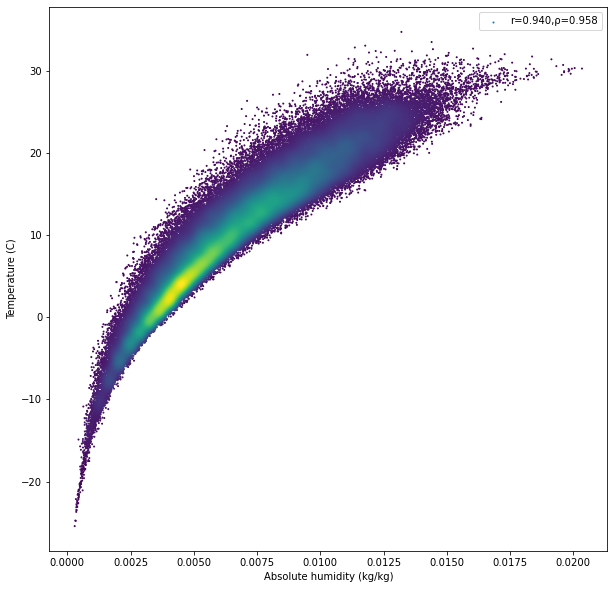

In [32]:
ax = density_scatter(EU_hum.to_numpy().flatten(), EU_tmp.to_numpy().flatten()-273.15, bins = [50,50], s=1)
ax.set_xlabel("Absolute humidity (kg/kg)")
ax.set_ylabel("Temperature (C)")
plt.legend()
plt.show()

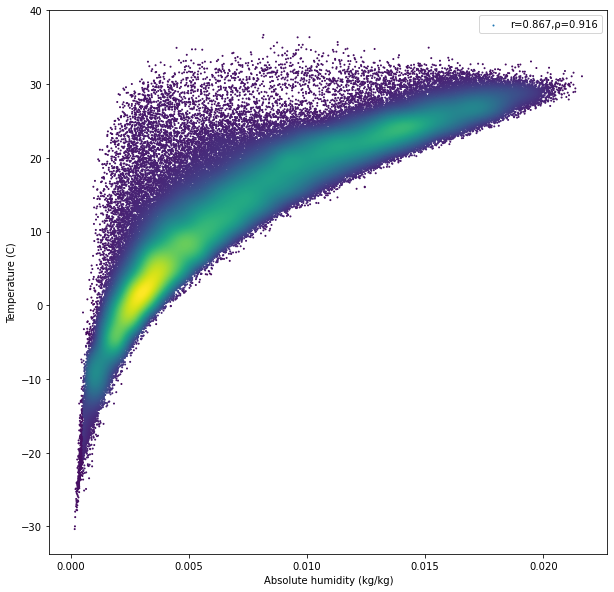

In [33]:
ax = density_scatter(US_hum.to_numpy().flatten(), US_tmp.to_numpy().flatten()-273.15, bins = [30,30], s=1)
ax.set_xlabel("Absolute humidity (kg/kg)")
ax.set_ylabel("Temperature (C)")
plt.legend()
plt.show()

#### Day <=> Sun

In [10]:
US_sun_long = pd.melt(US_sun, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "sun"})

In [11]:
US_day_long = pd.melt(US_day, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "daytime"})

In [12]:
US_sunday = US_sun_long.merge(US_day_long, on=["date", "state"])

In [13]:
EU_sun_long = pd.melt(EU_sun, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "sun"})
EU_day_long = pd.melt(EU_day, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "daytime"})
EU_sunday = EU_sun_long.merge(EU_day_long, on=["date", "state"])

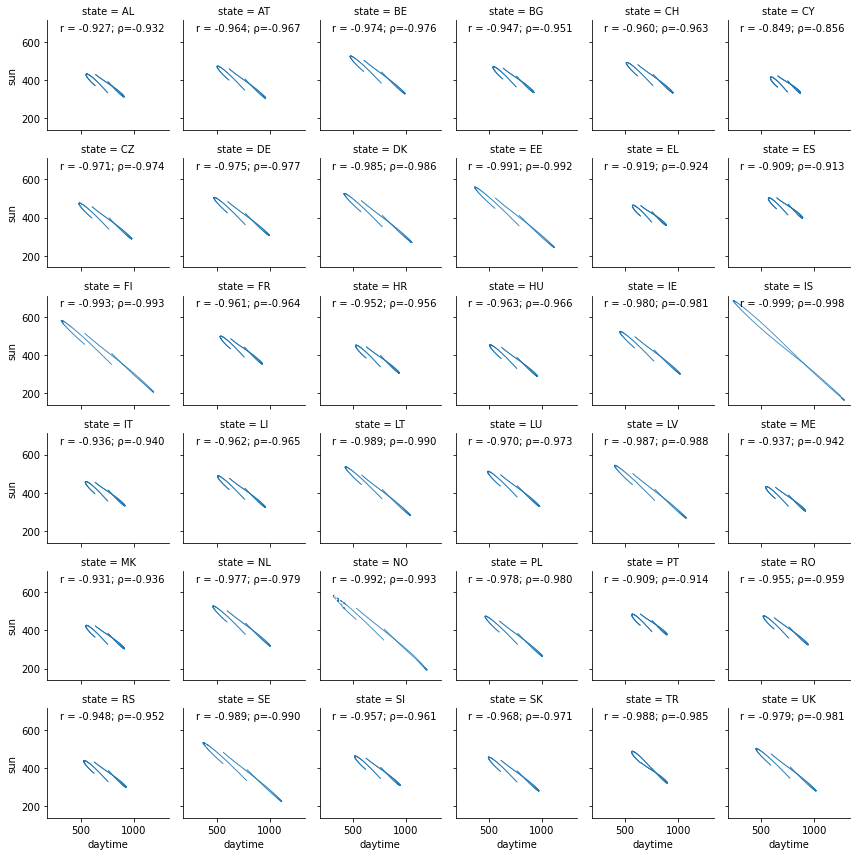

In [34]:
g = sns.FacetGrid(EU_sunday, col="state", col_wrap=6, height=2)
g.map(sns.scatterplot, "daytime", "sun", s=1, edgecolor="none")
g.map(corrfunc, "daytime", "sun")

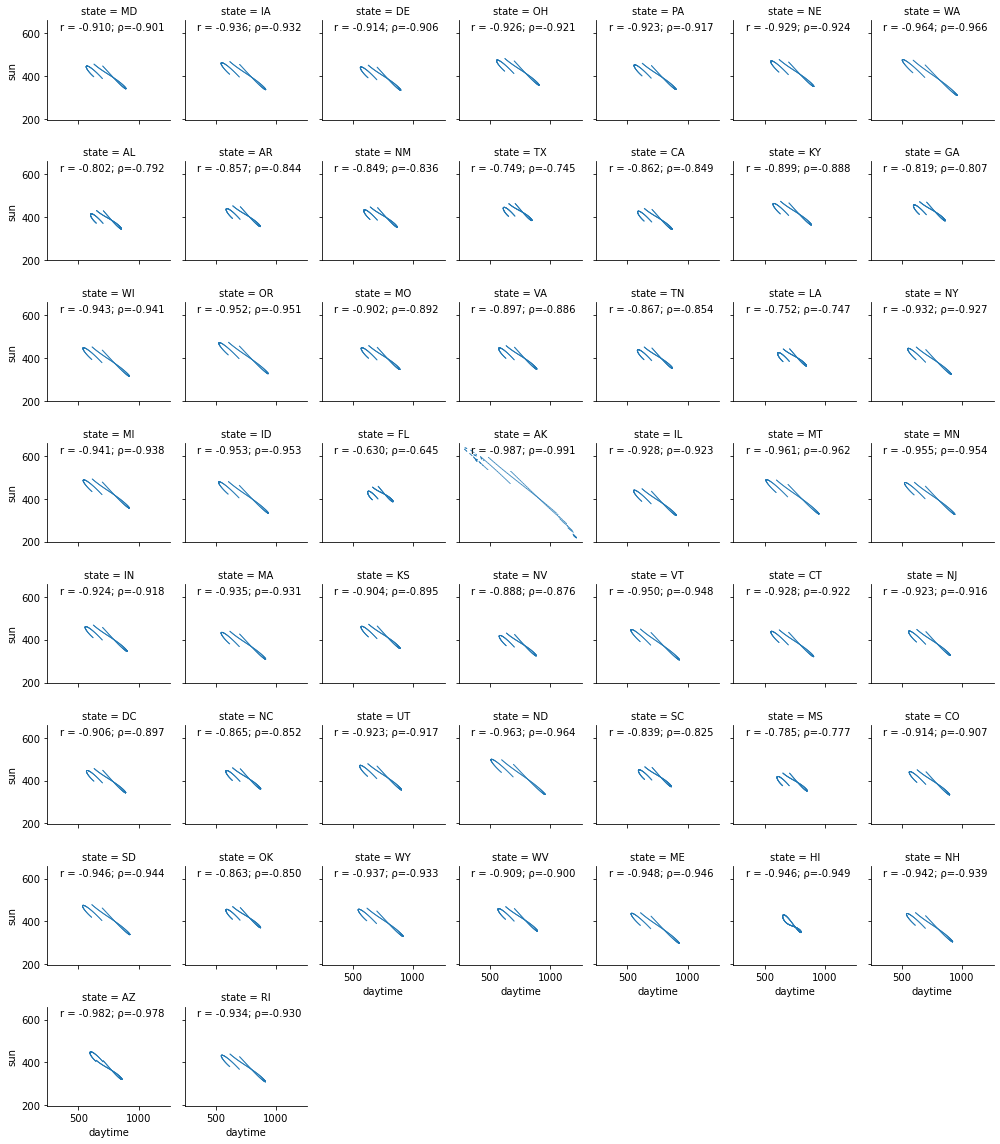

In [37]:
g = sns.FacetGrid(US_sunday, col="state", col_wrap=7, height=2)
g.map(sns.scatterplot, "daytime", "sun", s=1, edgecolor="none")
g.map(corrfunc, "daytime", "sun")

#### Day <=> Hum

In [26]:
US_aavg_tmp = pd.DataFrame(np.mean(US_tmp.to_numpy().reshape((365, -1, 51), order="F"), axis=1), index=US_day.index, columns=US_day.columns)
US_aavg_hum = pd.DataFrame(np.mean(US_hum.to_numpy().reshape((365, -1, 51), order="F"), axis=1), index=US_day.index, columns=US_day.columns)

In [27]:
EU_aavg_tmp = pd.DataFrame(np.mean(EU_tmp.to_numpy().reshape((365, -1, 36), order="F"), axis=1), index=EU_day.index, columns=EU_day.columns)
EU_aavg_hum = pd.DataFrame(np.mean(EU_hum.to_numpy().reshape((365, -1, 36), order="F"), axis=1), index=EU_day.index, columns=EU_day.columns)

In [28]:
US_hum_long = pd.melt(US_aavg_hum, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "humidity"})

In [29]:
US_dayhum = US_day_long.merge(US_hum_long, on=["date", "state"])

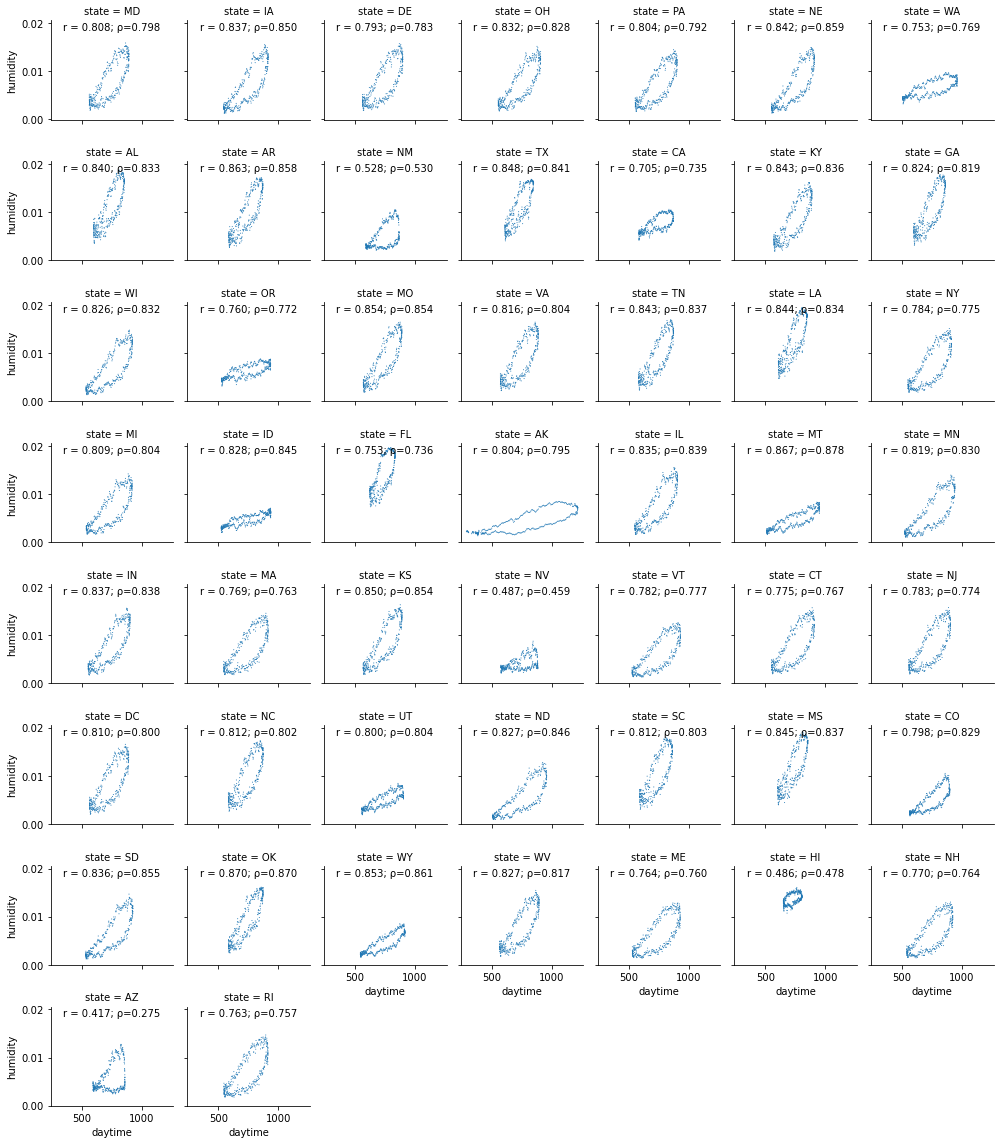

In [38]:
g = sns.FacetGrid(US_dayhum, col="state", col_wrap=7, height=2)
g.map(sns.scatterplot, "daytime", "humidity", s=1, edgecolor="none")
g.map(corrfunc, "daytime", "humidity")

In [39]:
EU_hum_long = pd.melt(EU_aavg_hum, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "humidity"})
EU_dayhum = EU_day_long.merge(EU_hum_long, on=["date", "state"])

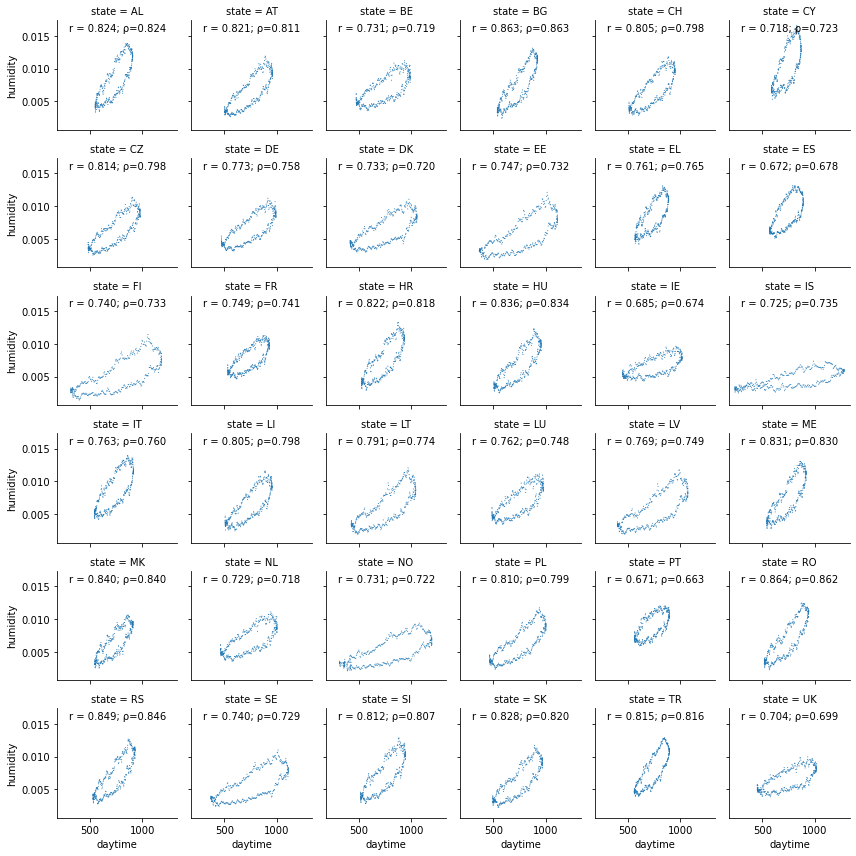

In [41]:
g = sns.FacetGrid(EU_dayhum, col="state", col_wrap=6, height=2)
g.map(sns.scatterplot, "daytime", "humidity", s=1, edgecolor="none")
g.map(corrfunc, "daytime", "humidity")

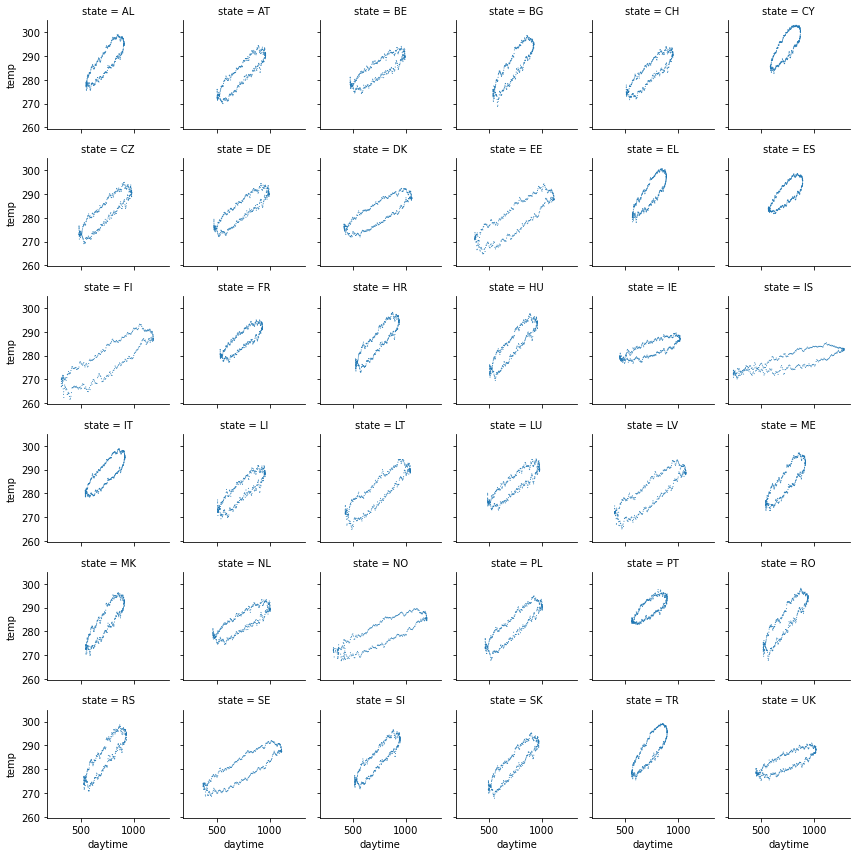

In [162]:
EU_tmp_long = pd.melt(EU_aavg_tmp, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "temp"})
EU_daytmp = EU_day_long.merge(EU_tmp_long, on=["date", "state"])

g = sns.FacetGrid(EU_daytmp, col="state", col_wrap=6, height=2)
g.map(sns.scatterplot, "daytime", "temp", s=1, edgecolor="none")

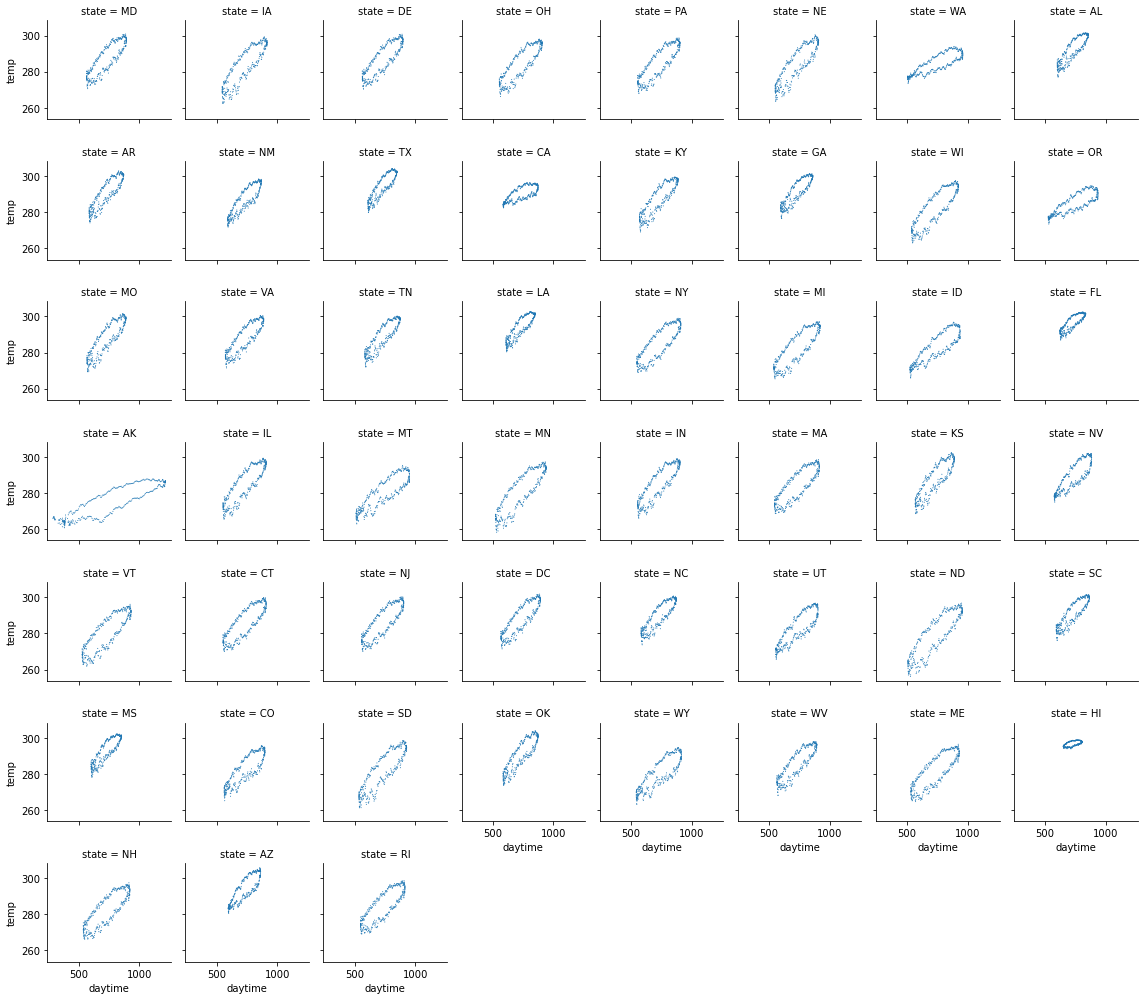

In [164]:
US_tmp_long = pd.melt(US_aavg_tmp, ignore_index=False).reset_index().rename(columns={"index": "date", "variable": "state", "value": "temp"})
US_daytmp = US_day_long.merge(US_tmp_long, on=["date", "state"])

g = sns.FacetGrid(US_daytmp, col="state", col_wrap=8, height=2)
g.map(sns.scatterplot, "daytime", "temp", s=1, edgecolor="none")

### Plot individual location

In [16]:
sunrise_daily = sunrise_df[region_OI]
humidity_daily = humidity_df[region_OI]

In [17]:
sunrise_daily.shape, humidity_daily.shape

((365,), (1826,))

<ipython-input-18-00b3507d12a3>:4: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  ax2 = fig.add_axes()


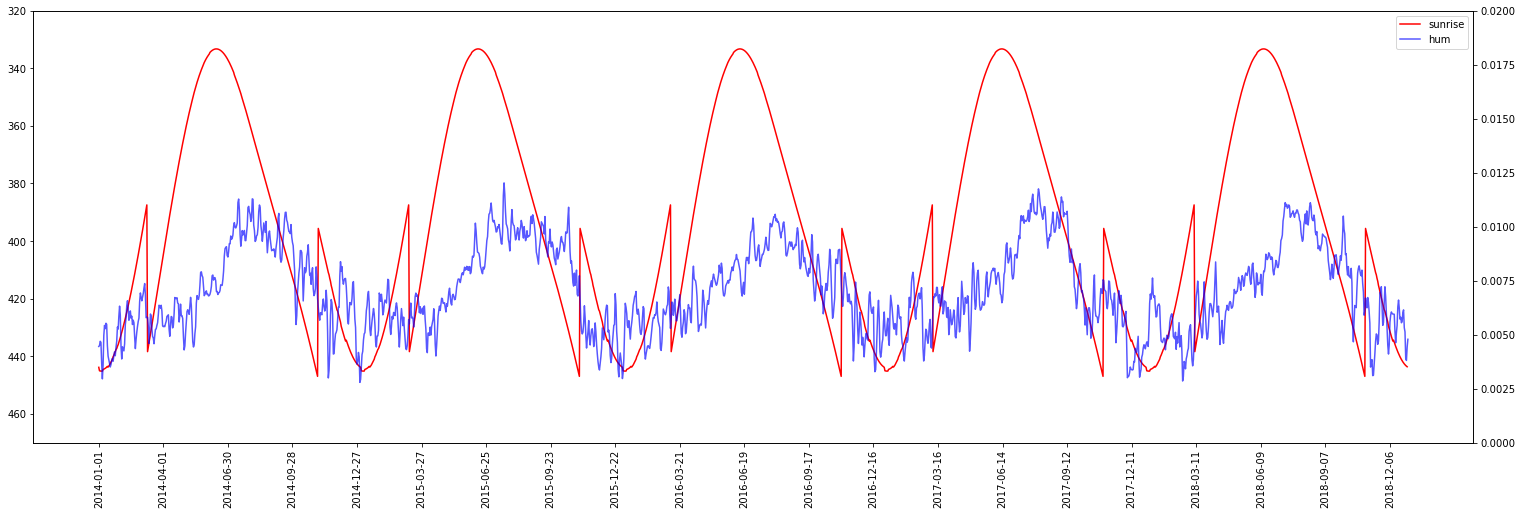

In [18]:
fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()

lns1 = ax1.plot(np.tile(sunrise_daily, 5), label="sunrise", color='red')
lns2 = ax2.plot(humidity_daily, label="hum", color='blue', alpha=0.66)
ax1.set_ylim(470, 320)
ax2.set_ylim(0, 0.02)
ax2.set_xticks(range(0, 1826, 90))
ax2.set_xticklabels(humidity_df['date'][range(0, 1826, 90)])

# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
ax2.tick_params(axis='x', labelrotation=90)
ax1.tick_params(axis='x', labelrotation=90)

#plt.savefig(f"Plots/humidity_sunrise_{region_OI}.pdf")

In [39]:
epi_df = pd.read_csv(f"compiled_data/epidemiology_{region_OI}.csv")

In [ ]:
vals = ["CoVHKU1", "CoVNL63", "CoVOC43", "CoV229E", "WILI"]
fig, ax = plt.subplots(figsize=(20, 5))

for val in vals:
    ax.plot(regional_df[val], label=val)
ax.legend()